# Udacity Self-Driving Car Nanodegree - Project 4: Advanced Lane Lines

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Initialization routines

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob('./test_images/*.jpg')))

# 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
def camera_calibration(calibration_path="./camera_cal/", dim=(9, 6)):
    #load imgs
    calibrationImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob(calibration_path + 'c*.jpg')))
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((dim[1]*dim[0],3), np.float32)
    objp[:,:2] = np.mgrid[0:dim[0],0:dim[1]].T.reshape(-1,2)
    
    imgpoints = []
    objpoints = []
    
    for fname, img in calibrationImages:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, dim, None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist, rvecs, tvecs

In [4]:
def load_calibration(calibration_file="./camera_cal.p"):
     return pickle.load(open(calibration_file, "rb" ))

In [5]:
def save_calibration(coefficients, calibration_file="./camera_cal.p"):
    pickle.dump(coefficients, open(calibration_file, "wb"))

In [6]:
save_calibration(camera_calibration())

# 2. Apply a distortion correction to raw images.

In [7]:
def undistort(img, cfx):
    return cv2.undistort(img, cfx[0], cfx[1], None, cfx[0])

## Test the distortion coefficients on example images.

In [8]:
cfx = camera_calibration()

True

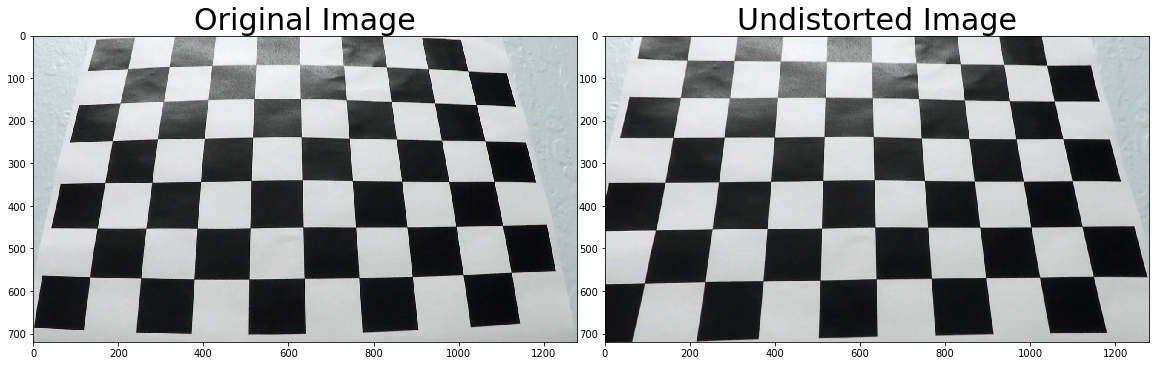

In [31]:
checkerboard_one = cv2.imread('./camera_cal/calibration3.jpg')
checkerboard_undistorted = undistort(checkerboard_one, cfx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(checkerboard_one)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(checkerboard_undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

cv2.imwrite('./output_images/undistorted_checkerboard.jpg', checkerboard_undistorted)

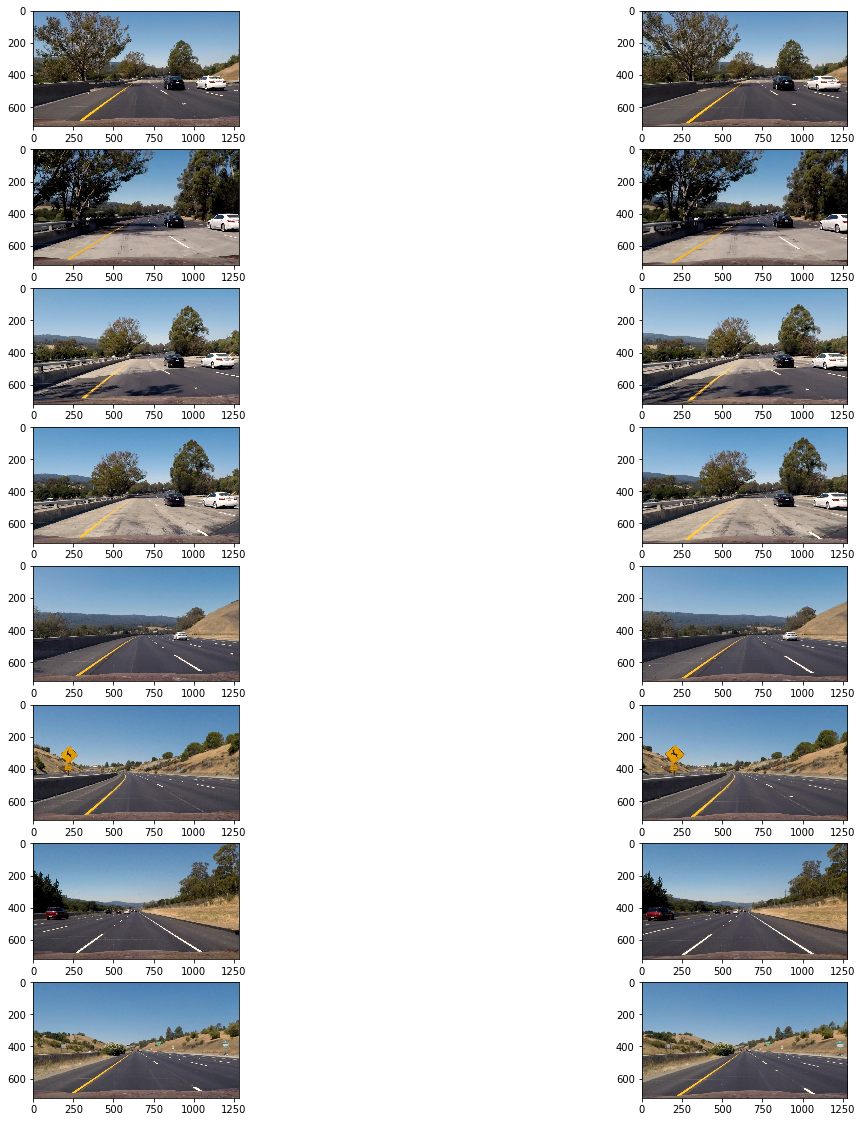

In [34]:
test_images_undistorted = []

for fname, img in testImages:
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = undistort(rgb, cfx)
    test_images_undistorted.append(dst)

f, axes = plt.subplots(len(testImages), 2, figsize=(20, 20))

for i in range(len(testImages)):
    axes[i, 0].imshow(cv2.cvtColor(testImages[i][1], cv2.COLOR_BGR2RGB))
    axes[i, 1].imshow(test_images_undistorted[i]) 
    cv2.imwrite('./output_images/undistort_example{}.jpg'.format(i), cv2.cvtColor(test_images_undistorted[i], cv2.COLOR_RGB2BGR))

# 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [11]:
def threshold_binary(img):

    # GRADIENTS
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 40
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Sobel Magnitude 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # threshold magnitude gradient
    thresh_min = 40
    thresh_max = 255
    mbinary = np.zeros_like(gradmag)
    mbinary[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    
    # Sobel direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # threshold direction gradient
    thresh_min = (2.0/6.0) * np.pi
    thresh_max = (4.0/6.0) * np.pi
    dbinary = np.zeros_like(absgraddir)
    dbinary[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1
    

    # combine gradients
    gradient_binary = np.zeros_like(dbinary) 
    gradient_binary[(sxbinary == 1) | ((mbinary == 1) & (dbinary == 1))] = 1
    
    
    # COLOR CHANNEL
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    thresh_min = 170
    thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh_min) & (s_channel <= thresh_max)] = 1
    

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(gradient_binary)
    combined_binary[(s_binary == 1) | (gradient_binary == 1)] = 1
    
    return combined_binary

## See the binary thresholds on example images.

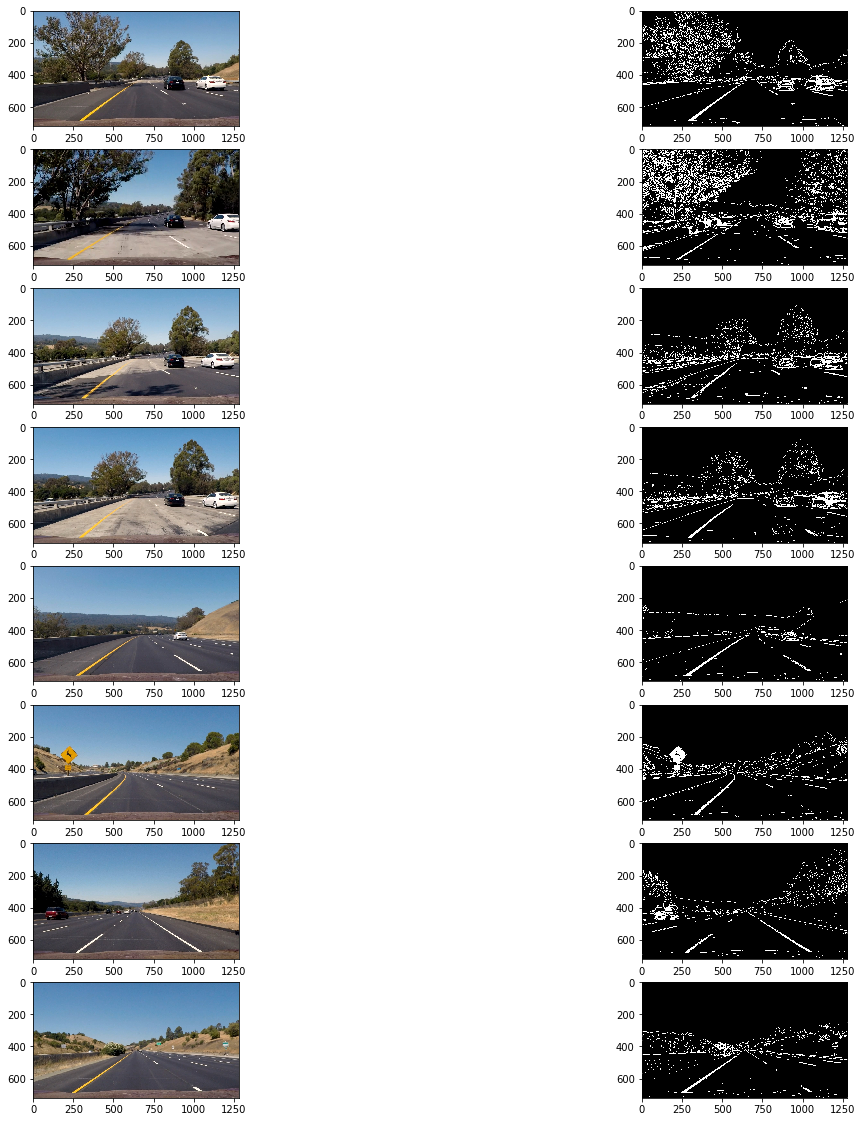

In [39]:
test_images_thresholded = []
for fname, img in testImages:
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    thresh = threshold_binary(rgb)
    test_images_thresholded.append(thresh)

f, axes = plt.subplots(len(testImages), 2, figsize=(20, 20))

for i in range(len(testImages)):
    axes[i, 0].imshow(cv2.cvtColor(testImages[i][1], cv2.COLOR_BGR2RGB))
    axes[i, 1].imshow(test_images_thresholded[i], cmap=plt.cm.gray)   

    cv2.imwrite('./output_images/thresh_example{}.jpg'.format(i), (test_images_thresholded[i].astype('uint8') * 255))

# 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [13]:
def perspective_transform(shape, corners=[(240,680),(578,460),(707,460),(1080,680)]):
    corners = np.float32(np.array(corners))
    width = float(shape[1])
    height = float(shape[0])
    
    offset = 400
    
    src = corners
    dst = np.array([[width/2 - offset, height],
                    [width/2 - offset, 0], 
                    [width/2 + offset, 0], 
                    [width/2 + offset, height]], dtype = 'float32')
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv
    
def warp_image(img, M):
    warped_output = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    return warped_output

## See transforms of example images.

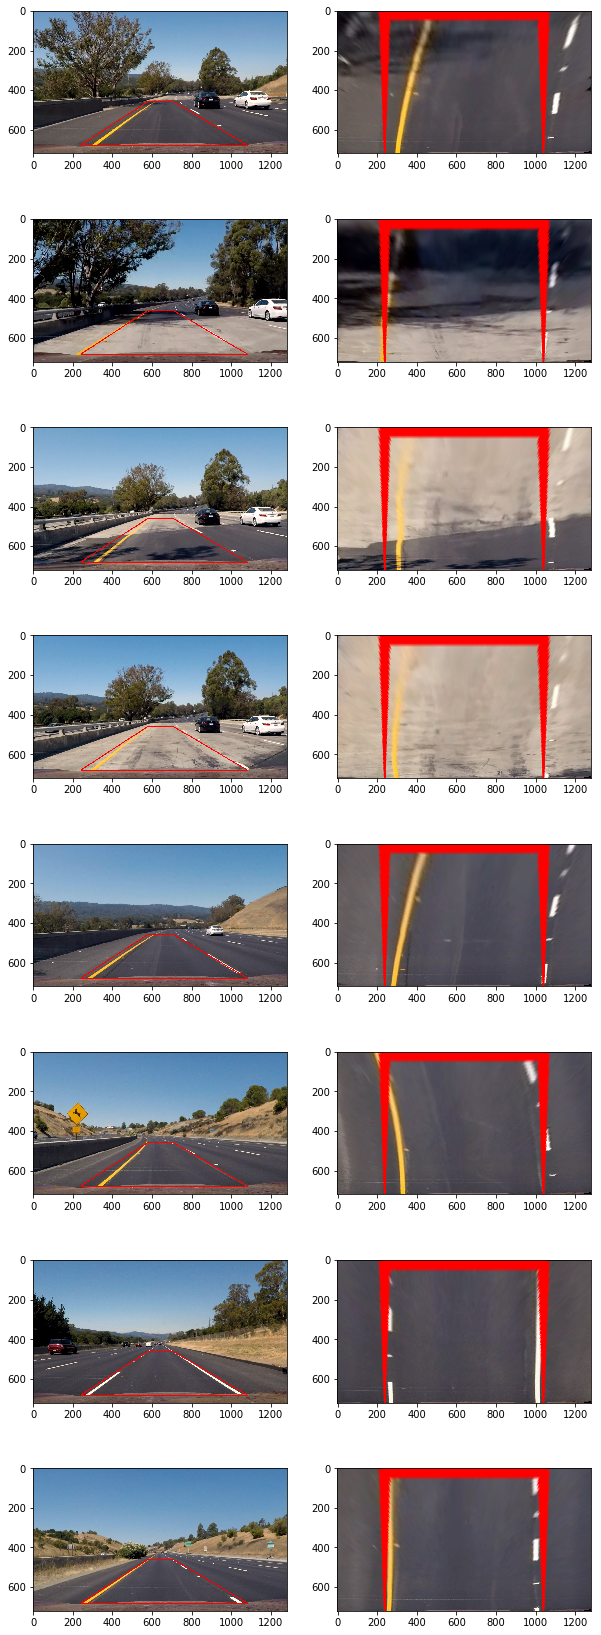

In [40]:
test_images_transformed = []
rgb_arr = []

corner_tuples=[(240,680),(578,460),(707,460),(1080,680)]

for fname, img in testImages:
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cv2.line(rgb, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=4)
    cv2.line(rgb, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=4)
    cv2.line(rgb, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=4)
    cv2.line(rgb, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=4)
    
    rgb_arr.append(rgb)
    
    M,_ = perspective_transform(rgb.shape)
    trans = warp_image(rgb, M)
    test_images_transformed.append(trans)

f, axes = plt.subplots(len(testImages), 2, figsize=(10, 30))

for i in range(len(testImages)):
    axes[i, 0].imshow(rgb_arr[i])
    axes[i, 1].imshow(test_images_transformed[i])   
    cv2.imwrite('./output_images/trans_example{}.jpg'.format(i), cv2.cvtColor(test_images_transformed[i], cv2.COLOR_RGB2BGR))

# 5. Detect lane pixels and fit to find the lane boundary.

In [15]:
def find_lane(binary_warped, img=False):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)\
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 10
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 4) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &  (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (255,255,0), 4) 
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (255,255,0), 4) 

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [int(255), 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, int(255)]
    if img == True:
        return [out_img, ploty, left_fitx, right_fitx, leftx, rightx]
    
    return [left_fit, right_fit]


def find_lane_prev(binary_warped, left_fit, right_fit):
    if left_fit == None or right_fit == None:
        return find_lane(binary_warped)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new = None
    right_fit_new = None
    
    HIT_THRESHOLD = 80
    
    if len(leftx) >= HIT_THRESHOLD and len(rightx) >= HIT_THRESHOLD:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
        right_fit_new = np.polyfit(righty, rightx, 2)
        
        return [left_fit_new, right_fit_new]
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

        left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
        right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
        
        #return [ploty, left_fitx, right_fitx, left_fit_new, right_fit_new]
    else:
        return find_lane(binary_warped)

## See lane fits on example images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


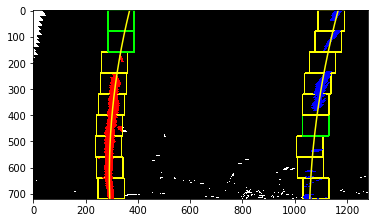

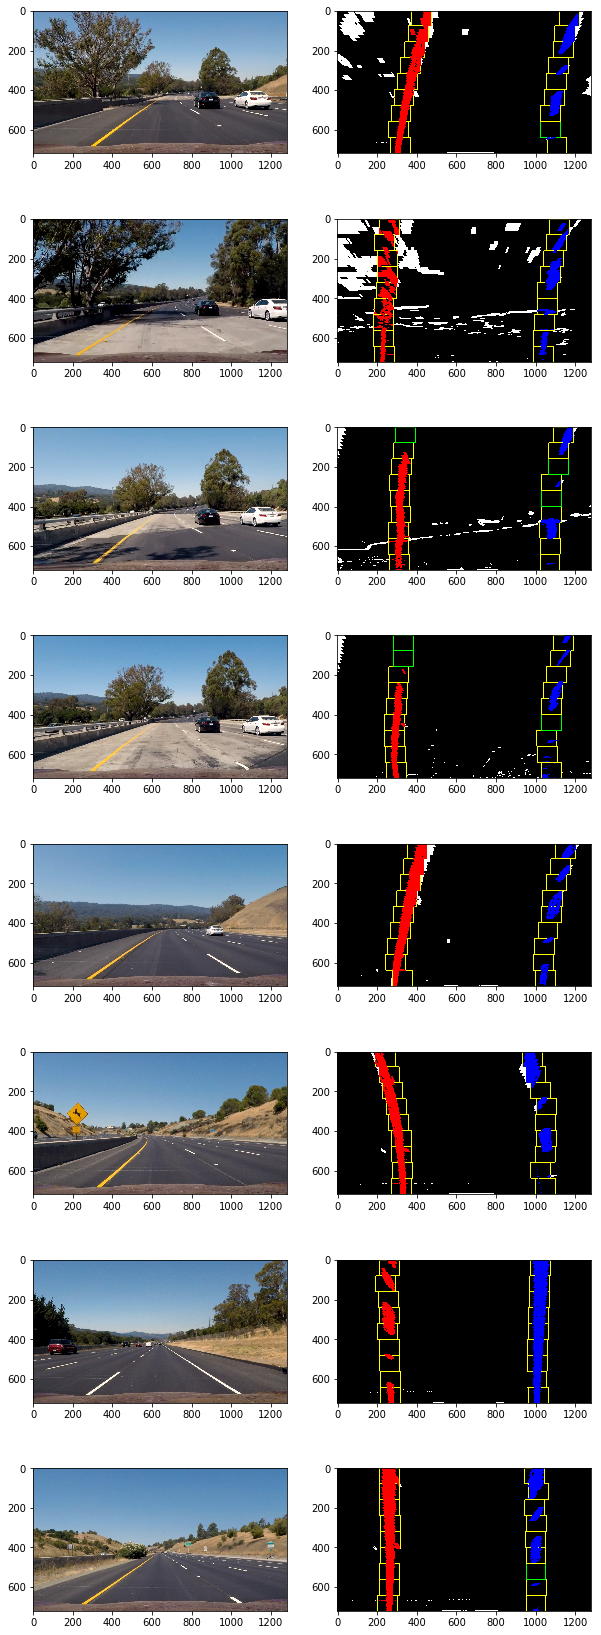

In [43]:
test_images_fl = []
rgb_arr = []

cfx = camera_calibration()

for fname, img in testImages:
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ud = undistort(rgb, cfx)
    tb = threshold_binary(ud)
    
    M, Minv = perspective_transform(rgb.shape)
    warp = warp_image(tb, M)

    fl = find_lane(warp, img=True)
    
    rgb_arr.append(rgb)
    test_images_fl.append(fl)
    
    
plt.imshow(test_images_fl[3][0])
plt.plot(test_images_fl[3][2], test_images_fl[3][1], color='yellow')
plt.plot(test_images_fl[3][3], test_images_fl[3][1], color='yellow')

f, axes = plt.subplots(len(testImages), 2, figsize=(10, 30))

for i in range(len(testImages)):
    axes[i, 0].imshow(rgb_arr[i])
    axes[i, 1].imshow(test_images_fl[i][0])
    cv2.imwrite('./output_images/lanes_example{}.jpg'.format(i), test_images_fl[i][0])


# 6. Determine the curvature of the lane and vehicle position with respect to center.

In [19]:
def curvature_center(ploty, leftx, rightx, left_fit, right_fit, width, y_eval=700):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    # Calculate vehicle center
    xMax = width
    yMax = y_eval
    vehicleCenter = xMax / 2
    lineLeft = left_fit[0]*yMax**2 + left_fit[1]*yMax + left_fit[2]
    lineRight = right_fit[0]*yMax**2 + right_fit[1]*yMax + right_fit[2]
    lineMiddle = (lineRight + lineLeft)/2
    
    diffFromVehicle = (lineMiddle - vehicleCenter) * xm_per_pix
        
    return (left_curverad, right_curverad, diffFromVehicle)

## See lane curvature of test images.

(2386.258546443733, 768.3480101882237, 0.27763836980235246)
(17563.41236948826, 1136.2989825699017, -0.027736163507639796)
(1461.2707313227857, 646.7006576786376, 0.2932595302965448)
(841.5868944198902, 1043.5578297002755, 0.18546550579754525)
(2480.911463325317, 930.3747355511609, 0.12464930971501806)
(703.5217871250555, 648.3603202809874, 0.2904853864858701)
(2586.431151219021, 101690.63833633959, -0.00595665563479968)
(4086.272843280916, 7779.694909298547, -0.030466762896413944)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


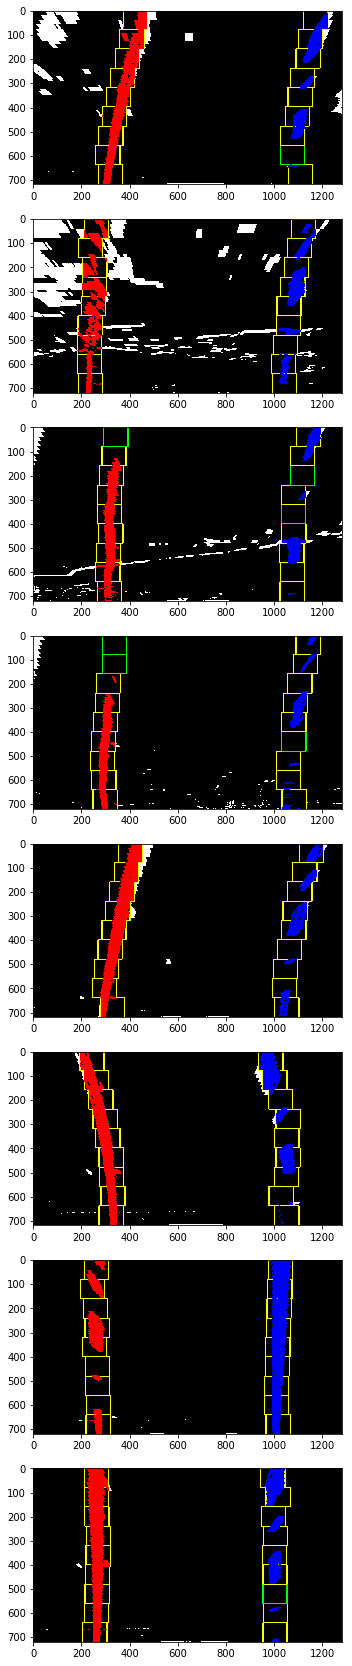

In [20]:
for fname, img in testImages:
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ud = undistort(rgb, cfx)
    tb = threshold_binary(ud)
    
    M, Minv = perspective_transform(rgb.shape)
    warp = warp_image(tb, M)

    fl = find_lane(warp)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    lx = fl[0][0]*ploty**2 + fl[0][1]*ploty + fl[0][2]
    rx = fl[1][0]*ploty**2 + fl[1][1]*ploty + fl[1][2]

    
    print(curvature_center(ploty, lx, rx, fl[0], fl[1], ud.shape[1]))

f, axes = plt.subplots(len(testImages), 1, figsize=(10, 30))

for i in range(len(testImages)):
    axes[i].imshow(test_images_fl[i][0])


# 7. Warp the detected lane boundaries back onto the original image.

In [23]:
def warp_back(warped, ploty, left_fitx, right_fitx, Minv, undist):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

## See lane bounds warped onto original example images.

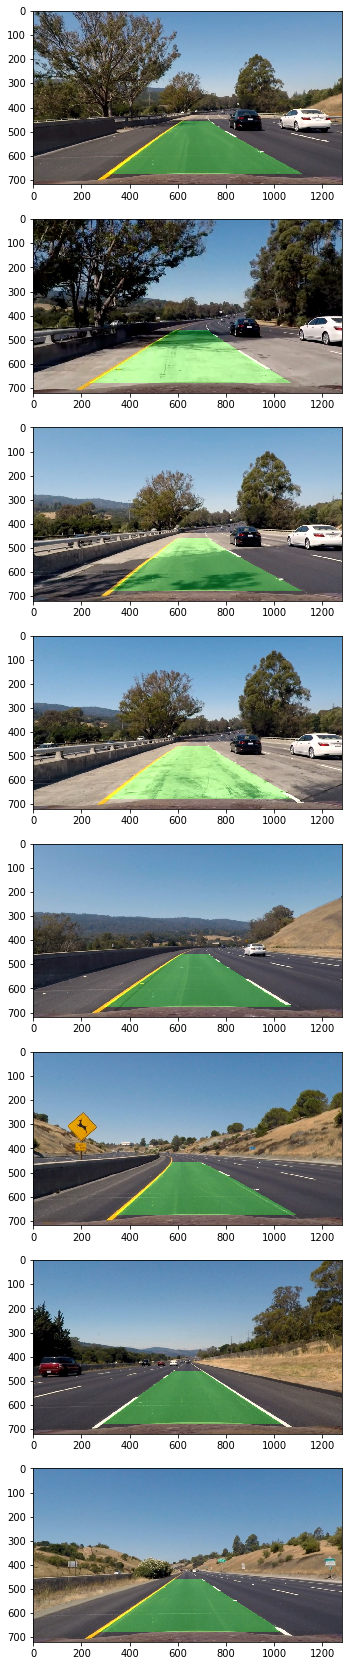

In [44]:
f, axes = plt.subplots(len(testImages), 1, figsize=(10, 30))
res_arr = []

for i in range(len(testImages)):
    img = testImages[i][1]
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    ud = undistort(rgb, cfx)
    tb = threshold_binary(ud)
    
    M, Minv = perspective_transform(rgb.shape)
    warp = warp_image(tb, M)

    fl = find_lane(warp)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    lx = fl[0][0]*ploty**2 + fl[0][1]*ploty + fl[0][2]
    rx = fl[1][0]*ploty**2 + fl[1][1]*ploty + fl[1][2]
    
    res = warp_back(warp, ploty, lx, rx, Minv, ud)
    axes[i].imshow(res)
    res_arr.append(res)
    cv2.imwrite('./output_images/lane_bounds_example{}.jpg'.format(i), cv2.cvtColor(res, cv2.COLOR_RGB2BGR))

# 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [25]:
def visual_output(curvature_offset, res):
    lcr = curvature_offset[0]
    rcr = curvature_offset[1]
    offset = curvature_offset[2]
    
    message1 = "Curve radius: {:.2f}".format((lcr + rcr)/(2 * 1000.0)) + " km"
    
    message3 = "Offset: "
    
    offset *= 100
    if offset < 0:
        message3 += '{:.0f} cm right'.format(-offset)
    else:
        message3 += '{:.0f} cm left'.format(offset)
    
    message3 += " of center."
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(res, message1, (50, 250)[::-1], font, 2, fontColor, 2)
    cv2.putText(res, message3, (200, 250)[::-1], font, 2, fontColor, 2)

    return res

## Test visual output on example images.

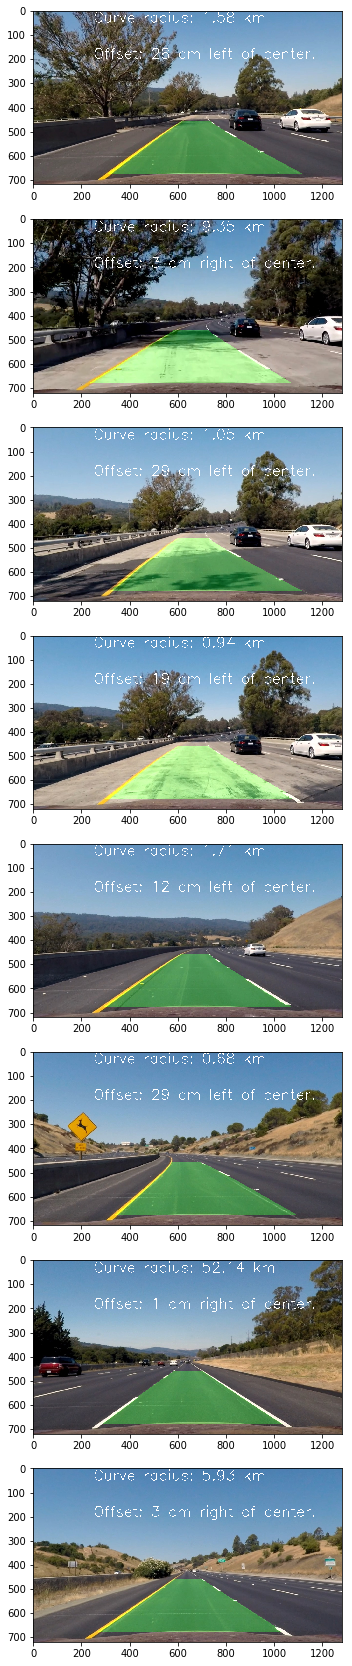

In [26]:
f, axes = plt.subplots(len(testImages), 1, figsize=(10, 30))

for i in range(len(testImages)):
    img = testImages[i][1]
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    ud = undistort(rgb, cfx)
    tb = threshold_binary(ud)
    
    M, Minv = perspective_transform(rgb.shape)
    warp = warp_image(tb, M)

    fl = find_lane(warp)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    lx = fl[0][0]*ploty**2 + fl[0][1]*ploty + fl[0][2]
    rx = fl[1][0]*ploty**2 + fl[1][1]*ploty + fl[1][2]
    
    res = warp_back(warp, ploty, lx, rx, Minv, ud)
    
    carinfo = curvature_center(ploty, lx, rx, fl[0], fl[1], ud.shape[1])
    
    res = visual_output(carinfo, res)
    
    axes[i].imshow(res)


# Full Pipeline

In [27]:
from moviepy.editor import VideoFileClip
from collections import deque
class LaneManager():
    def __init__(self, queue_size=5, extra_smoothing=1):
        self.left_fit = None
        self.right_fit = None

        self.leftCurvature = None
        self.rightCurvature = None
        
        self.queue_left = deque()
        self.queue_right = deque()
        
        self.queue_size = queue_size
        
        self.extra_smoothing = extra_smoothing
        
        
    # recursive function for "number smoothing" - one smoothing level means replace the last element added (the actual current frame fit) with the current average of deque and then reaverage for the output "mean fit" on frame; level two will replace that last element (the average of the deque) with another average of the current deque, which will skew the average further to past frames, resulting in an ultra-smooth lane detector (but at the cost of sucking at highly curved lines where the fit changes a lot in reality)
    def frame_fit(self, img, left_fit, right_fit, smooth_count):
        if len(self.queue_left) == self.queue_size:
            self.queue_left.popleft()
            self.queue_right.popleft()
        
        self.queue_left.append(left_fit)
        self.queue_right.append(right_fit)
        
        left_arr = np.array(self.queue_left)
        right_arr = np.array(self.queue_right)
        
        left_fit_mean = np.mean(left_arr, axis=0)
        right_fit_mean = np.mean(right_arr, axis=0)
        
        if len(self.queue_left) == self.queue_size and smooth_count > 0:
            self.queue_left.pop()
            self.queue_right.pop()
            
            return self.frame_fit(img, left_fit_mean, right_fit_mean, smooth_count - 1)    
        
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )

        left_fitx = left_fit_mean[0]*ploty**2 + left_fit_mean[1]*ploty + left_fit_mean[2]
        right_fitx = right_fit_mean[0]*ploty**2 + right_fit_mean[1]*ploty + right_fit_mean[2]
        
        return ploty, left_fitx, right_fitx, left_fit_mean, right_fit_mean
    
    
input_image_shape = None

def imgprocline(inputImageLine):
    global lane_manager
    global input_image_shape
    
    input_image_shape = inputImageLine.shape
    
    ud = undistort(inputImageLine, cfx)
    tb = threshold_binary(ud)
    
    M, Minv = perspective_transform(inputImageLine.shape)
    warp = warp_image(tb, M)

    fits = find_lane_prev(warp, lane_manager.left_fit, lane_manager.right_fit)
    fl = lane_manager.frame_fit(ud, fits[0], fits[1], lane_manager.extra_smoothing)
    
    resq = warp_back(warp, fl[0], fl[1], fl[2], Minv, ud)
    
    carinfo = curvature_center(fl[0], fl[1], fl[2], fl[3], fl[4], ud.shape[1])
    
    resq = visual_output(carinfo, resq)
        
    return resq
    
def videoPipeline(inputVideo, outputVideo):
    myclip = VideoFileClip(inputVideo)
    clip = myclip.fl_image(imgprocline)
    %time clip.write_videofile(outputVideo, audio=False)
    print(input_image_shape)

In [ ]:
# Project video
lane_manager = LaneManager(10, extra_smoothing=0)
videoPipeline('project_videos/project_video.mp4', 'output_videos/project_video.mp4')

Yay!

In [ ]:
#challenge video
lane_manager = LaneManager(30, extra_smoothing=0)
videoPipeline('project_videos/challenge_video.mp4', 'output_videos/challenge_video.mp4')

Oof.

In [ ]:
#harder challenge
lane_manager = LaneManager(5, extra_smoothing=0)
videoPipeline('project_videos/harder_challenge_video.mp4', 'output_videos/harder_challenge_video.mp4')

Even more oof.